# Using a Deep Q-Network on a multi-stock portfolio

## Retrieving Data

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.fundamentaldata import FundamentalData
import numpy as np
import yfinance as yf
api_key = "s61NxSH07BLaoJhz5GIUcvhf0JJHm5Bg"

### Function to retrieve data

In [58]:
def retrieve_data(tickr):

    data = yf.download(tickr)
    columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    data.columns = columns
    data = data.sort_index(ascending=True)
    data['Change Percentage'] = data['Close'].pct_change() * 100
    data['Force Index'] = data['Close'].diff() * data['Volume']
    
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    raw_money_flow = typical_price * data['Volume']
    money_flow_direction = typical_price.diff()
    positive_flow = raw_money_flow.where(money_flow_direction > 0, 0)
    negative_flow = raw_money_flow.where(money_flow_direction < 0, 0)
    positive_mf = positive_flow.rolling(window=14, min_periods=0).sum()
    negative_mf = negative_flow.rolling(window=14, min_periods=0).sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        money_ratio = positive_mf / negative_mf
        data['Money Flow Index'] = 100 - (100 / (1 + money_ratio))
        data['Money Flow Index'].replace([np.inf], 100, inplace=True)

    data['Price-Volume'] = (data['Close'].pct_change() * data['Volume']).cumsum()
    data['Standard Deviation'] = data['Close'].rolling(window=20).std()
    
    earnings_df = get_earnings(tickr)
    data = data.join(earnings_df, how='left')
    data['eps'].fillna(method='ffill', inplace=True)

    data['daily_pe_ratio'] = data.apply(
        lambda row: row['Close'] / row['eps'] if row['eps'] > 0 else None,
        axis=1
    )

    
    print(data.info)
    return data

In [59]:
def get_earnings(ticker):
    url = f"https://financialmodelingprep.com/api/v3/earnings-surprises/{ticker}?apikey={api_key}"
    response = requests.get(url)
    earnings_data = response.json()


    earnings_df = pd.DataFrame(earnings_data)
    earnings_df = earnings_df[['date', 'actualEarningResult']]
    earnings_df.rename(columns={'actualEarningResult': 'eps'}, inplace=True)
    earnings_df['date'] = pd.to_datetime(earnings_df['date'])
    earnings_df.set_index('date', inplace=True)
    return earnings_df

### Seperating test and train data

In [52]:
def split_data(data, start, end, test_start, test_end):
    train_data = data.loc[start : end]
    test_data = data.loc[test_start : test_end]
    return train_data, test_data

Creating close price dataframe

In [53]:
def retrieve_close(train_data, test_data):
    train_close = train_data['Close']
    test_close = test_data['Close']
    return train_close, test_close

### Normalising data

In [54]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

def PCA_transform(train_data, test_data):
    # Scaling train data
    state_features = pd.DataFrame({
        'Change Percentage': train_data['Change Percentage'],
        'Force Index': train_data['Force Index'],
        'Money Flow Index': train_data['Money Flow Index'],
        'Price-Volume': train_data['Price-Volume'],
        'Standard Deviation': train_data['Standard Deviation'],
        'daily_pe_ratio': train_data['daily_pe_ratio']
    })
    scaler = MinMaxScaler() # Creating scaler object
    scaled_features_array = scaler.fit_transform(state_features)
    scaled_data = pd.DataFrame(scaled_features_array, columns=state_features.columns, index=state_features.index)

    # Train data PCA transform
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(scaled_data)

    # Scaling test data
    test_features = pd.DataFrame({
        'Change Percentage': test_data['Change Percentage'],
        'Force Index': test_data['Force Index'],
        'Money Flow Index': test_data['Money Flow Index'],
        'Price-Volume': test_data['Price-Volume'],
        'Standard Deviation': test_data['Standard Deviation'],
        'daily_pe_ratio': test_data['daily_pe_ratio']
    })
    scaled_test_features_array = scaler.transform(test_features) # Using ssame scaler object as train data
    scaled_test_data = pd.DataFrame(scaled_test_features_array, columns=test_features.columns)

    # PCA transform on test data
    X_test_pca = pca.transform(scaled_test_data)

    return X_train_pca, X_test_pca



### Creating multi-stock vector

In [55]:
asset_tickers = ['AAPL', 'ABBV', 'MSFT']

In [90]:
assets_close = []
def get_vector(asset_tickers):
    assets_train_close = []
    assets_test_close = []

    assets_train_pca = []
    assets_test_pca = []
    for i in asset_tickers:
        data = retrieve_data(i)
        data_train, data_test = split_data(data, '2019-01-01', '2021-12-31', '2022-01-01', '2023-12-31')
        
        data_train_close, data_test_close = retrieve_close(data_train, data_test)
        assets_train_close.append(data_train_close)
        assets_test_close.append(data_test_close)

        data_train_pca, data_test_pca = PCA_transform(data_train, data_test)
        assets_train_pca.append(data_train_pca)
        assets_test_pca.append(data_test_pca)

    return assets_train_close, assets_test_close, assets_train_pca, assets_test_pca
train_close, test_close, train_pca, test_pca = get_vector(asset_tickers)

[*********************100%***********************]  1 of 1 completed
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_93530/205035607.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Money Flow Index'].replace([np.inf], 100, inplace=True)
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_93530/205035607.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method w

<bound method DataFrame.info of                    Open         High          Low        Close     Volume  \
Date                                                                        
1980-12-12   0.09859664   0.09902530   0.09859664   0.09859664  469033600   
1980-12-15   0.09345278   0.09388144   0.09345278   0.09388144  175884800   
1980-12-16   0.08659355   0.08702220   0.08659355   0.08702220  105728000   
1980-12-17   0.08873682   0.08916547   0.08873682   0.08873682   86441600   
1980-12-18   0.09130952   0.09173817   0.09130952   0.09130952   73449600   
...                 ...          ...          ...          ...        ...   
2025-07-17 210.02000427 211.80000305 209.58999634 210.57000732   48068100   
2025-07-18 211.17999268 211.78999329 209.69999695 210.86999512   48974600   
2025-07-21 212.47999573 215.77999878 211.63000488 212.10000610   51377400   
2025-07-22 214.39999390 214.94999695 212.22999573 213.13999939   46404100   
2025-07-23 214.14999390 215.14999390 212.410

[*********************100%***********************]  1 of 1 completed
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_93530/205035607.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Money Flow Index'].replace([np.inf], 100, inplace=True)
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_93530/205035607.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method w

<bound method DataFrame.info of                    Open         High          Low        Close    Volume  \
Date                                                                       
2013-01-02  21.04910660  21.21692564  20.43777120  20.92923651  13767900   
2013-01-03  20.87529564  20.97718372  20.47373122  20.97718372  16739300   
2013-01-04  20.61158562  20.91125974  20.52767723  20.74943544  21372100   
2013-01-07  20.65353394  21.24688953  20.46773750  20.46773750  17897100   
2013-01-08  20.20401764  20.76141138  19.99424678  20.55164053  17863300   
...                 ...          ...          ...          ...       ...   
2025-07-17 191.39999390 192.11999512 188.25999451 189.00000000   4853100   
2025-07-18 189.25999451 192.33999634 188.57000732 191.50999451   5332000   
2025-07-21 184.85000610 189.89999390 184.63000488 189.61999512   4954800   
2025-07-22 187.11000061 188.19999695 184.89999390 184.94000244   4432100   
2025-07-23 190.55000305 190.80000305 186.77000427 187.05

[*********************100%***********************]  1 of 1 completed
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_93530/205035607.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Money Flow Index'].replace([np.inf], 100, inplace=True)


<bound method DataFrame.info of                    Open         High          Low        Close      Volume  \
Date                                                                         
1986-03-13   0.05959758   0.06225864   0.05427670   0.05427670  1031788800   
1986-03-14   0.06172596   0.06279074   0.05959760   0.05959760   308160000   
1986-03-17   0.06279077   0.06332286   0.06172598   0.06172598   133171200   
1986-03-18   0.06119389   0.06332286   0.06066181   0.06279077    67766400   
1986-03-19   0.06012969   0.06172596   0.05959761   0.06119387    47894400   
...                 ...          ...          ...          ...         ...   
2025-07-17 511.70001221 513.36999512 505.61999512 505.67999268    17503100   
2025-07-18 510.04998779 514.64001465 507.42999268 514.47998047    21209700   
2025-07-21 510.05999756 512.09002686 505.54998779 506.70999146    14066800   
2025-07-22 505.26998901 511.20001221 505.26998901 510.97000122    13868600   
2025-07-23 505.86999512 506.7900

/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_93530/205035607.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['eps'].fillna(method='ffill', inplace=True)
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_93530/205035607.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['eps'].fillna(method='ffill', inplace=True)


## Creating Deep Q Network

### Setting up environment

In [61]:
import itertools
import math
ATOMIC_HOLDINGS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
STOCKS = ['STOCK_A', 'STOCK_B', "stock c"]

all_possible_combos = itertools.product(ATOMIC_HOLDINGS, repeat=len(STOCKS))

ACTIONS = [
    list(combo) for combo in all_possible_combos if sum(combo) <= 1.0
]

In [77]:
class environment:

    def __init__(self, price_data, PCA_data):
        self.data = price_data
        self.assets_pca = PCA_data
        self.cash_balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = [0,0,0] # Number of shares owned for each stock in portfolio
        self.trend = None
        self.balance_history = []
        self.price = None
        self.rewards = []
        self.total_reward = 0
        self.total = 100
        self.trades = []
        self.action_history = []
        self.weight_vector = [0,0,0]
        self.return_history = []


    #Action = [1,0,0]
    #Action = [-0.5,0.5,0]
    
        

    def step(self, action):

        stocks = self.data
        stock1 = stocks[0]
        trade = [] 
        if self.index <= len(stock1):
            data = self.data
            index = self.index
            old_net_worth = self.get_net_worth()
            total = self.get_net_worth()
            cash_balance = self.cash_balance
            trade.append(total)
            trade.append(action)
            cash_weight = 1
            for i in action:
                cash_weight -= i
                
            for i in range(len(action)):
                stock_data = self.data[i]
                

                current_weight = (self.num_shares[i] * stock_data.iloc[self.index]) / total
                
                trade.append(current_weight)
                trade.append(action)
                self.action_history.append(action[i])
                
                
                

                # Checking if action should buy or sell stock
                if action[i] > current_weight:

                    # Calculating cash amount to buy
                    to_buy = (action[i] - current_weight) * total

                    
                    

                    # Calculating new number of shares
                    new_shares = to_buy / stock_data.iloc[self.index]

                    # Adding new shares to total shares
                    self.num_shares[i] += new_shares

                    

                
                elif action[i] < current_weight:
                    to_sell = (current_weight - action[i]) * total
                    shares_to_sell = to_sell / stock_data.iloc[self.index]
                    new_num_shares = self.num_shares[i] - shares_to_sell
                    self.num_shares[i] = new_num_shares
                    
                        
            self.cash_balance = total * cash_weight
            self.balance_history.append(old_net_worth)



            
            annual_rate = 0.054
            # Daily risk-free rate
            daily_rate = annual_rate / 365
            self.cash_balance = self.cash_balance * (1+ daily_rate)
            trade.append(self.num_shares)
            trade.append(self.cash_balance)
            

            if self.index < (len(stock1)-1):
                self.index += 1
                volatility_window = 7 
    
        
                if self.index > volatility_window:
        
                    historical_data_window = [
                        asset.iloc[self.index - volatility_window : self.index] for asset in self.data
                    ]
        
        
                    asset_returns_window = [data.pct_change().dropna() for data in historical_data_window]
        
                    asset_returns_matrix = np.array(asset_returns_window).T
        
       
                    projected_portfolio_returns = np.dot(asset_returns_matrix, action)
        
        
                    forward_looking_volatility = np.std(projected_portfolio_returns)
                else:
                    forward_looking_volatility = 0.0

                # Defining how much the model should focus on reducing risk
                risk_aversion_gamma = 0 
    
                
                
                new_net_worth = self.get_net_worth()
                
                # The reward is the change in value
                portfolio_return = (new_net_worth - old_net_worth) / old_net_worth
                self.return_history.append(portfolio_return)

                reward = portfolio_return - (risk_aversion_gamma * forward_looking_volatility)
                
                self.trades.append(trade)
                self.total_reward += reward
                self.rewards.append(self.total_reward)
                self.weight_vector = action
        
            else:
                self.index += 1
                reward = 0
            return (reward, False)
        else:
            return (0, True)
        
    def reset(self):
        self.cash_balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = [0,0,0]
        self.trend = None
        self.balance_history = []
        self.trades = []
        self.weight_vector = [0,0,0]
        self.return_history = []
    
    def get_net_worth(self):
        data = self.data
        total = 0
        num_shares = self.num_shares
        for i in range(len(num_shares)):
            price_data = data[i]
            total += num_shares[i] * price_data.iloc[self.index]
        total += self.cash_balance
        return total
        
    def get_state(self):
        state = []
        
        for i in range(len(self.assets_pca)):
            stock_pca = self.assets_pca[i]
            

            current_pca = stock_pca[self.index]
          
            for i in current_pca:
                state.append(i)
        return state


### Training the model

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import itertools
import math

# Create the Stock Environment
def train_model(env):
    
    
    # Neural network model for approximating Q-values
    class DQN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(DQN, self).__init__()
            self.fc1 = nn.Linear(input_dim, 256)
            self.fc2 = nn.Linear(256, 256)
            self.fc3 = nn.Linear(256, 256)
            self.fc4 = nn.Linear(256, output_dim)
        
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = torch.relu(self.fc3(x))
            return self.fc4(x)
    
    # Hyperparameters
    learning_rate = 0.001
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995
    batch_size = 64
    target_update_freq = 1000
    memory_size = 10000
    episodes = 2000
    
    ATOMIC_HOLDINGS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    STOCKS = ['STOCK_A', 'STOCK_B', 'Stock c']
    
    all_possible_combos = itertools.product(ATOMIC_HOLDINGS, repeat=len(STOCKS))
    
    ACTIONS = [
        list(combo) for combo in all_possible_combos if sum(combo) <= 1.0
    ]
    
    # Initialize Q-networks
    input_dim = 14
    output_dim = 286
    policy_net = DQN(input_dim, output_dim)
    target_net = DQN(input_dim, output_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = deque(maxlen=memory_size)
    
    # Function to choose action using epsilon-greedy policy
    def select_action(state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, len(ACTIONS) - 1)  # Explore
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = policy_net(state)
            return torch.argmax(q_values).item()
            
    
    # Function to optimize the model using experience replay
    def optimize_model():
        if len(memory) < batch_size:
            return
        
        batch = random.sample(memory, batch_size)
    
        state_batch, action_batch, reward_batch, next_state_batch = zip(*batch)
        state_batch = torch.FloatTensor(np.array(state_batch, dtype=np.float32))
    
        state_batch = torch.FloatTensor(state_batch)
        
     
        action_batch = torch.LongTensor(action_batch).unsqueeze(1)
        reward_batch = torch.FloatTensor(reward_batch)
        next_state_batch = torch.FloatTensor(next_state_batch)
        
    
        # Compute Q-values for current states
    
        # Now the gather operation will work
        q_values = policy_net(state_batch).gather(1, action_batch).squeeze()
    
        # Compute target Q-values using the target network
        with torch.no_grad():
            max_next_q_values = target_net(next_state_batch).max(1)[0]
            target_q_values = reward_batch + gamma * max_next_q_values
    
        loss = nn.MSELoss()(q_values, target_q_values)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Main training loop
    steps_done = 0
    
    for episode in range(episodes):
        state = env.get_state()
        done = False
        i = 0
        for i in range(len(train_close[i])-1):
            # Select action
            action_index = select_action(state, epsilon)
           
            action = ACTIONS[action_index]
            reward, done = env.step(action)
            
            next_state = env.get_state()
            # Store transition in memory
            memory.append((state, action_index, reward, next_state))
            
            # Update state
            state = next_state
    
            # Optimize model
            optimize_model()
            steps_done += 1
    
            # Update target network periodically
            if steps_done % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())
    
    
        # Decay epsilon
        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        env.reset()
    return policy_net

## Testing

In [82]:
def test(env, policy_net):
    
    # Reset the environment
    env.reset()  

    step = 0
    done = False
    action_history = []
    sum = 0
    stock1 = test_close[0]
    
    while env.index < (len(stock1)):
   
        state = env.get_state()
       
     
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
            action_index = torch.argmax(q_values).item()
            
            action = ACTIONS[action_index]
       

        env.step(action)
        sum += 1
        
     

        if done:
            break
   

In [65]:
returns = []
for i in range(1):
    env = environment(train_close, train_pca)
    policy_net = train_model(env)
    test_env = environment(test_close, test_pca)
    test(test_env, policy_net)
    returns.append((test_env.balance_history[-1] - test_env.balance_history[0]) / test_env.balance_history[0])
    print(i)    

0


In [92]:
total = 0
for i in returns:
    total += i
avg = total/len(returns)
print(avg)
print(returns)

0.4037660823401586
[0.4037660823401586]


In [93]:
daily_std = np.std(test_env.return_history)
annual_std = daily_std * np.sqrt(252)
sharpe_ratio = avg / annual_std

print(annual_std)
print(sharpe_ratio)

0.1654176309079846
2.440889040206107


In [94]:
aapl = test_close[0]
abbv = test_close[1]
msft = test_close[2]
totalr = 0
for i in test_close:
    r = (i[-1] - i[0]) / i[0]
    r = r * 0.33333
    totalr += r
print(totalr)

0.1594062915332846


/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_93530/4213828171.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r = (i[-1] - i[0]) / i[0]


### Plotting model performace against underlying stock price

In [95]:
df1 = pd.DataFrame(test_close[0])
df1.columns = ['Close']
df1['Model_Balance'] = test_env.balance_history
print(df1)

                  Close  Model_Balance
Date                                  
2022-01-03 174.54291721   100.00000000
2022-01-04 179.25417452   101.08116796
2022-01-05 176.29001709   100.39540183
2022-01-06 169.50772130    98.96196475
2022-01-07 169.69421065    98.30681716
...                 ...            ...
2023-12-22 193.76106625   139.55812575
2023-12-26 192.20248714   139.20681611
2023-12-27 191.09062872   138.87695053
2023-12-28 192.72861012   139.47157313
2023-12-29 192.49036071   139.34913790

[501 rows x 2 columns]


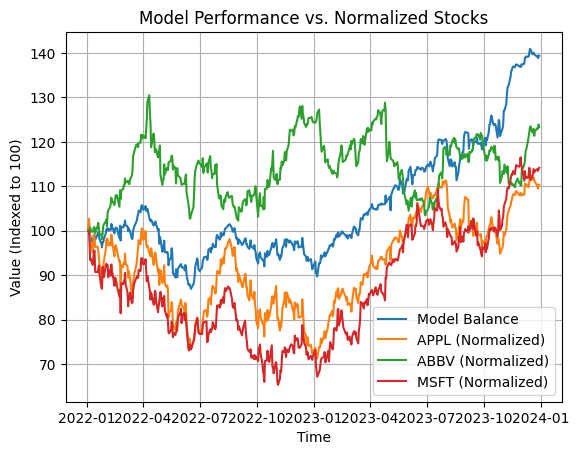

In [96]:
appl_scaled = (test_close[0] / test_close[0].iloc[0]) * 100
abbv_scaled = (test_close[1] / test_close[1].iloc[0]) * 100
msft_scaled = (test_close[2] / test_close[2].iloc[0]) * 100

# Plot the data
plt.plot(df1['Model_Balance'], label="Model Balance")
plt.plot(appl_scaled, label="APPL (Normalized)")
plt.plot(abbv_scaled, label="ABBV (Normalized)")
plt.plot(msft_scaled, label="MSFT (Normalized)")

plt.title("Model Performance vs. Normalized Stocks")
plt.xlabel("Time")
plt.ylabel("Value (Indexed to 100)")
plt.legend()
plt.grid(True)
plt.savefig("model_performance_2022-2023.png")
plt.show()

In [75]:
equal_weight_df = pd.DataFrame({
    'Stock0': test_close[0],
    'Stock1': test_close[1],
    'Stock2': test_close[2]
})

# 2. Calculate the daily percentage returns for each stock
daily_asset_returns = equal_weight_df.pct_change().dropna()

# 3. Define the equal weights for the portfolio
# In this case, 1/3 for each of the three stocks.
weights = np.array([1/3, 1/3, 1/3])

# 4. Calculate the daily returns of the equally weighted portfolio
# This is the dot product of the asset returns and their weights.
equal_weight_returns = np.dot(daily_asset_returns, weights)

In [76]:
baseline_day_std = np.std(equal_weight_returns)
baseline_year_std = baseline_day_std * np.sqrt(252)
baseline_sharpe = totalr / baseline_year_std
print(totalr)
print(baseline_sharpe)

0.15940616009821373
0.7470239676217949


In [89]:
print(test_env.trades)

[[100.0, [0.9, 0.0, 0.1], 0.0, [0.9, 0.0, 0.1], 0.0, [0.9, 0.0, 0.1], 0.0, [0.9, 0.0, 0.1], [0.296075909371928, 0.10861398614061028, 0.0], -2.775968191996657e-15], [97.21382528210671, [0.4, 0.1, 0.0], 0.9017042824504541, [0.4, 0.1, 0.0], 0.0, [0.4, 0.1, 0.0], 0.09829571754954586, [0.4, 0.1, 0.0], [0.296075909371928, 0.10861398614061028, 0.0], 48.61410380073176], [97.3358721815361, [0.9, 0.0, 0.1], 0.40025407983708816, [0.9, 0.0, 0.1], 0.10029897720991593, [0.9, 0.0, 0.1], 0.0, [0.9, 0.0, 0.1], [0.296075909371928, 0.10861398614061028, 0.0], -2.702012851161965e-15], [96.38417058514372, [0.9, 0.0, 0.1], 0.9008794501805987, [0.9, 0.0, 0.1], 0.0, [0.9, 0.0, 0.1], 0.09912054981940123, [0.9, 0.0, 0.1], [0.296075909371928, 0.10861398614061028, 0.0], -2.675593917563388e-15], [99.60357291117353, [0.9, 0.0, 0.1], 0.9017351290053625, [0.9, 0.0, 0.1], 0.0, [0.9, 0.0, 0.1], 0.09826487099463749, [0.9, 0.0, 0.1], [0.296075909371928, 0.10861398614061028, 0.0], -2.7649635021063758e-15], [99.516891112869